In [1]:
############### Confounding varaibles

In [4]:
import pandas as pd
import os
import torch
import numpy as np
import scipy.stats as stats
from pprint import pprint

from sklearn.metrics import (
    auc,
    matthews_corrcoef,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    classification_report,
)

confounding_variables = pd.read_csv("/storage/scratch/groshchupkin/Tom_dataset/confounding_variables.csv")

config = {
    "runs_folder": "final_data_2",
    "results_folder": "/storage/scratch/groshchupkin/Tom_dataset/results/",
    "data_path": "/storage/scratch/groshchupkin/Tom_dataset/"
}
class_info = "classification_info_test.csv"

runs_folder = os.listdir(config["results_folder"] + config["runs_folder"])
run_paths = {
    "bionet": dict(),
    "logreg": dict(),
}

for folder in runs_folder:
    if "bionet" in folder:
        seed = folder.split("_")[-1]
        run_paths["bionet"][f"seed_{seed}"] = config["results_folder"] + config["runs_folder"] + f"/{folder}/"
    else:
        seed = folder.split("_")[-1]
        run_paths["logreg"][f"seed_{seed}"] = config["results_folder"] + config["runs_folder"] + f"/{folder}/"

dataset = pd.read_csv("/storage/scratch/groshchupkin/Tom_dataset/dataset.csv")
dataset['rowid'] = dataset.index
mapping_rowid_ergoid = dataset[['ergoid', 'rowid']]
# onfounding_variables

In [78]:
############ Plot depressed by gender
woman = 1
man = 0
labels = dataset.iloc[:, :3]
merged_df = pd.merge(labels, confounding_variables, on='ergoid', how='inner')
merged_df.loc[merged_df['sex'] == woman]['depression_label'].value_counts()

depression_label
0.0    535
1.0     62
Name: count, dtype: int64

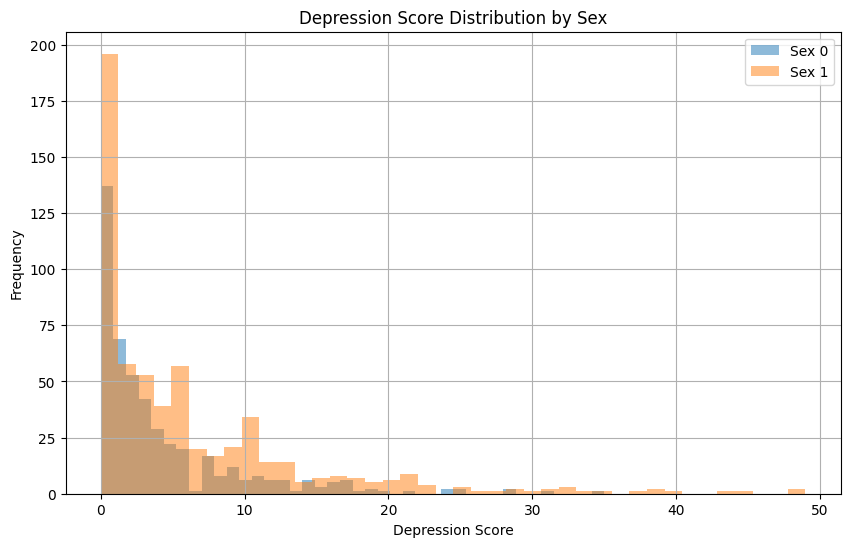

In [41]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# for sex in [0, 1]:
#     subset = merged_df[merged_df['sex'] == sex]
#     plt.hist(subset['depression_score'], bins=40, alpha=0.5, label=f'Sex {sex}')

# plt.xlabel('Depression Score')
# plt.ylabel('Frequency')
# plt.title('Depression Score Distribution by Sex')
# plt.legend()
# plt.grid(True)
# plt.show()

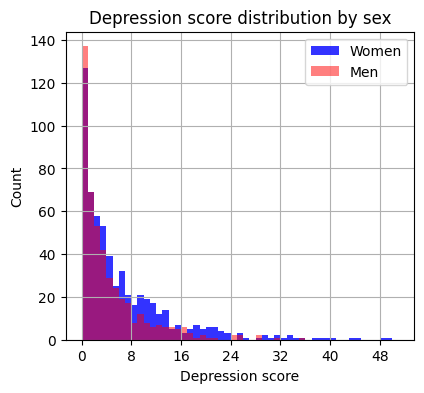

In [98]:
# Separate the data by sex
df = merged_df
women_scores = df[df['sex'] == 1]['depression_score']
men_scores = df[df['sex'] == 0]['depression_score']

# Plotting the histograms
plt.figure(figsize=(4.5, 4))

# Histogram for women
plt.hist(women_scores, bins=range(0, 52, 1), alpha=0.8, label='Women', color="blue")

# Histogram for men
plt.hist(men_scores, bins=range(0, 52, 1), alpha=0.5, label='Men', color="red")

plt.xlabel('Depression score')
plt.ylabel('Count')
plt.title('Depression score distribution by sex')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 52, 8))
plt.savefig("dep_score_distribution_by_sex.png")
plt.show()

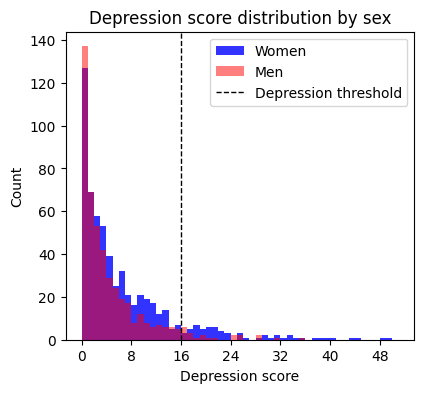

In [103]:
df = merged_df
women_scores = df[df['sex'] == 1]['depression_score']
men_scores = df[df['sex'] == 0]['depression_score']

# Plotting the histograms
plt.figure(figsize=(4.5, 4))

# Histogram for women
plt.hist(women_scores, bins=range(0, 52, 1), alpha=0.8, label='Women', color="blue")

# Histogram for men
plt.hist(men_scores, bins=range(0, 52, 1), alpha=0.5, label='Men', color="red")

# Adding a vertical line at depression score of 16
plt.axvline(x=16, color='black', linestyle='--', linewidth=1, label='Depression threshold')

plt.xlabel('Depression score')
plt.ylabel('Count')
plt.title('Depression score distribution by sex')
plt.legend()
# plt.grid(True)
plt.xticks(range(0, 52, 8))
plt.savefig("dep_score_distribution_by_sex.png")
plt.show()

In [51]:
import json

results_data = {
    "mcc": {
        "bionet": {
            "men": [],
            "women": [],
        },
        "logreg": {
            "men": [],
            "women": [],
        },
    },
    "f1_score": {
        "bionet": {
            "men": [],
            "women": [],
        },
        "logreg": {
            "men": [],
            "women": [],
        },
    },
    "auc_pr": {
        "bionet": {
            "men": [],
            "women": [],
        },
        "logreg": {
            "men": [],
            "women": [],
        },
    },
    "roc_auc": {
        "bionet": {
            "men": [],
            "women": [],
        },
        "logreg":{
            "men": [],
            "women": [],
        },
    },
}

#  I need to collect performances here

# First you need to get performances

for model_type in ["bionet", "logreg"]:
    for _, seed_path in run_paths[model_type].items():
        seed_misclass = pd.read_csv(seed_path + class_info)
        men_seed_test_preds, men_seed_test_labels = [], []
        women_seed_test_preds, women_seed_test_labels = [], []
        
        for _, row in seed_misclass.iterrows():
            original_index = round(row['original_index'])
            true_class = round(row['true_class'])
            predicted_class = round(row['predicted_class'])
    
            # Determine gender
            ergoid_value = mapping_rowid_ergoid.loc[mapping_rowid_ergoid['rowid'] == original_index, 'ergoid'].values[0]
            sex_val = confounding_variables.loc[confounding_variables['ergoid'] == ergoid_value]['sex'].values[0]
            
            if sex_val == 1: # WOMAN
                women_seed_test_preds.append(predicted_class)
                women_seed_test_labels.append(true_class)
            elif sex_val == 0: # MAN
                men_seed_test_preds.append(predicted_class)
                men_seed_test_labels.append(true_class)
            else:
                print("problem")
        
        results_data["mcc"][model_type]["men"].append(matthews_corrcoef(men_seed_test_labels, men_seed_test_preds))
        results_data["mcc"][model_type]["women"].append(matthews_corrcoef(women_seed_test_labels, women_seed_test_preds))

        results_data["f1_score"][model_type]["men"].append(f1_score(men_seed_test_labels, men_seed_test_preds))
        results_data["f1_score"][model_type]["women"].append(f1_score(women_seed_test_labels, women_seed_test_preds))

        results_data["roc_auc"][model_type]["men"].append(roc_auc_score(men_seed_test_labels, men_seed_test_preds))
        results_data["roc_auc"][model_type]["women"].append(roc_auc_score(women_seed_test_labels, women_seed_test_preds))

        precision, recall, _ = precision_recall_curve(men_seed_test_labels, men_seed_test_preds)
        men_test_auc_pr = auc(recall, precision)
        results_data["auc_pr"][model_type]["men"].append(men_test_auc_pr)
        
        precision, recall, _ = precision_recall_curve(women_seed_test_labels, women_seed_test_preds)
        women_test_auc_pr = auc(recall, precision)
        results_data["auc_pr"][model_type]["women"].append(women_test_auc_pr)


In [54]:
from scipy import stats
results_statistics = {
    "mcc": {
        "bionet": {
            "men": dict(),
            "women": dict(),
        },
        "logreg": {
            "men": dict(),
            "women": dict(),
        },
    },
    "f1_score": {
        "bionet": {
            "men": dict(),
            "women": dict(),
        },
        "logreg": {
            "men": dict(),
            "women": dict(),
        },
    },
    "auc_pr": {
        "bionet": {
            "men": dict(),
            "women": dict(),
        },
        "logreg": {
            "men": dict(),
            "women": dict(),
        },
    },
    "roc_auc": {
        "bionet": {
            "men": dict(),
            "women": dict(),
        },
        "logreg": {
            "men": dict(),
            "women": dict(),
        },
    },
}
combined_statistics = True
for metric_type in results_data:
    for model_type in ["bionet", "logreg"]:
        men_res_data = results_data[metric_type][model_type]["men"]
        women_res_data = results_data[metric_type][model_type]["women"]
        
        results_statistics[metric_type][model_type]["men"]["mean"] = np.mean(men_res_data)
        results_statistics[metric_type][model_type]["men"]["std"] = np.std(men_res_data, ddof=1)  # ddof=1 to get the sample standard deviation

        results_statistics[metric_type][model_type]["women"]["mean"] = np.mean(women_res_data)
        results_statistics[metric_type][model_type]["women"]["std"] = np.std(women_res_data, ddof=1)
    
    if combined_statistics:
        t_statistic_bionet, p_value_bionet = stats.ttest_ind(results_data[metric_type]["bionet"]["men"], 
                                             results_data[metric_type]["bionet"]["women"], equal_var=False)
        t_statistic_logreg, p_value_logreg = stats.ttest_ind(results_data[metric_type]["logreg"]["men"], 
                                             results_data[metric_type]["logreg"]["women"], equal_var=False)
        
        results_statistics[metric_type]["bionet"]["t_statistic"] = t_statistic_bionet
        results_statistics[metric_type]["bionet"]["p_value"] = p_value_bionet
        results_statistics[metric_type]["bionet"]["statistically_significant"] = p_value_bionet < 0.05

        results_statistics[metric_type]["logreg"]["t_statistic"] = t_statistic_logreg
        results_statistics[metric_type]["logreg"]["p_value"] = p_value_logreg
        results_statistics[metric_type]["logreg"]["statistically_significant"] = p_value_logreg < 0.05

pprint(results_statistics)

{'auc_pr': {'bionet': {'men': {'mean': 0.32810558075634,
                               'std': 0.13554704106133164},
                       'p_value': 2.1485929312493677e-06,
                       'statistically_significant': True,
                       't_statistic': -4.9187785740830945,
                       'women': {'mean': 0.40533606308145553,
                                 'std': 0.07924400383040163}},
            'logreg': {'men': {'mean': 0.21593272051974527,
                               'std': 0.1462158842330059},
                       'p_value': 3.5311010921970738e-06,
                       'statistically_significant': True,
                       't_statistic': -4.793146858306535,
                       'women': {'mean': 0.3000911621857044,
                                 'std': 0.09720865204506146}}},
 'f1_score': {'bionet': {'men': {'mean': 0.1654496853492308,
                                 'std': 0.08332586366504761},
                         'p_value': 5.2694